# **Setup**

In [ ]:
pip install stockstats

In [ ]:
import pandas_datareader.data as web
import datetime as dt
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import seaborn as sns
from stockstats import StockDataFrame as Sdf
import scipy 
import pywt
from sklearn.metrics import confusion_matrix
import math
from pandas.tseries.offsets import CustomBusinessDay, DateOffset, WeekOfMonth
from pandas.tseries.holiday import sunday_to_monday, AbstractHolidayCalendar, Holiday, USMemorialDay, USLaborDay, USColumbusDay, USThanksgivingDay
from sklearn import metrics
from rpy2.robjects import pandas2ri
import rpy2.robjects as objects 
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
import warnings
warnings.filterwarnings('ignore')
print("pandas version %s" % pd.__version__)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


pandas version 1.1.5


In [ ]:
sns.set(rc={'figure.figsize':(20, 7)})

In [ ]:
# Code to read csv file into Colaboratory:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Load dataset from google drive
id = '1ATmaZrLwm1_hE1I1p7s2S1rjpLXv1ozx'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('dataset.xlsx')

# **Preprocessing**

---

**Hypothesis: Assume that the missing values of the series (weekly, monthly) are constant until the date of publication of a new data item.** 

---



In [ ]:
df_BcBalance = pd.read_excel("dataset.xlsx", sheet_name = 'Bilan BC')
df_BcBalance.set_index('Date', inplace = True, drop = True)
df_BcBalance = df_BcBalance.resample('D').fillna(method = 'ffill')

df_daily_data = pd.read_excel("dataset.xlsx", sheet_name = 'Données journalières')
df_daily_data.set_index('Date', inplace = True, drop = True)
del df_daily_data['CRB - Bétail']

df_EconomicalSurprise = pd.read_excel("dataset.xlsx", sheet_name = 'Surprise économique')
df_EconomicalSurprise.set_index('Date', inplace = True, drop = True)
df_EconomicalSurprise = df_EconomicalSurprise.resample('D').fillna(method = 'ffill')

df_FedBalance = pd.read_excel("dataset.xlsx", sheet_name = 'Bilan FED')
df_FedBalance.set_index('Date', inplace = True, drop = True)
df_FedBalance = df_FedBalance.resample('D').fillna(method = 'ffill')

df_gold = pd.read_excel("dataset.xlsx", sheet_name = 'Or')
df_gold.set_index('Date', inplace = True, drop = True)
df_gold = df_gold.resample('D').fillna(method = 'ffill')

df_InflationUnemployment = pd.read_excel("dataset.xlsx", sheet_name = 'Chômage & Inflation')
df_InflationUnemployment.set_index('Date', inplace = True, drop = True)
df_InflationUnemployment = df_InflationUnemployment.resample('D').fillna(method = 'ffill')

df_oil = pd.read_excel("dataset.xlsx", sheet_name = 'Pétrole')
df_oil.set_index('Date', inplace = True, drop = True)
df_oil = df_oil.resample('D').fillna(method = 'ffill')

df_ProductionCapacity = pd.read_excel("dataset.xlsx", sheet_name = 'Capacité de production')
df_ProductionCapacity.set_index('Date', inplace = True, drop = True)
df_ProductionCapacity = df_ProductionCapacity.resample('D').fillna(method = 'ffill')

df_SPX = pd.DataFrame(df_daily_data['SPX Index'].copy())
df_SPX.index = df_daily_data.index.copy()
#del df_daily_data['SPX Index']

df_daily_data = df_daily_data.join(df_BcBalance).join(df_EconomicalSurprise).join(df_gold).join(df_InflationUnemployment).join(df_ProductionCapacity)
df_daily_data = df_daily_data[(df_daily_data.index >= '2000-12-31') & (df_daily_data.index <= '2019-12-31')]

df_SPX = pd.DataFrame(df_daily_data['SPX Index'].copy())
df_SPX.index = df_daily_data.index.copy()
df_daily_data.head(10)

,SPX Index,Vix Index,GDP US,Taux 10 ans US,FDTR Index,Indice CRB,CRB - Métaux,CRB - Industrie de base,CRB - Alimentaire,CRB - Textile,MACD,BSPGCPUS Index,Surprise économique,Or,Chômage US,Confiance des consommateurs US,Inflation US,CPTICHNG Index
Date,,,,,,,,,,,,,,,,,,
2000-12-31,0.00,26.85,3.0,5.112,6.5,223.99,214.03,255.81,184.74,245.74,0.000000,5.7,-0.218,272.0,3.9,128.55,3.4,79.9609
2001-01-01,0.00,26.85,3.0,5.114,6.5,223.99,214.03,255.81,184.74,245.74,0.000000,5.7,-0.218,272.0,3.9,128.55,3.4,79.9609
2001-01-02,-2.80,29.99,3.0,4.915,6.5,222.54,211.24,253.76,183.96,244.15,-15.078643,5.7,-0.218,270.0,3.9,128.55,3.4,79.9609
2001-01-03,5.01,26.60,3.0,5.158,6.0,222.53,210.76,253.53,184.17,244.15,-11.375763,5.7,-0.218,269.3,3.9,128.55,3.4,79.9609
2001-01-04,-1.06,26.97,3.0,5.039,6.0,222.80,210.62,253.95,184.29,243.49,-9.479367,5.7,-0.218,268.4,3.9,128.55,3.4,79.9609
2001-01-05,-2.62,28.67,3.0,4.931,6.0,223.70,210.83,254.36,185.68,243.43,-10.676785,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609
2001-01-06,0.00,28.67,3.0,4.931,6.0,223.70,210.83,254.36,185.68,243.43,0.000000,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609
2001-01-07,0.00,28.67,3.0,4.931,6.0,223.70,210.83,254.36,185.68,243.43,0.000000,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609
2001-01-08,-0.19,29.84,3.0,4.956,6.0,224.48,211.59,255.17,186.40,244.80,-11.691893,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609


In [ ]:
sns.set(rc={'figure.figsize':(20, 9)})

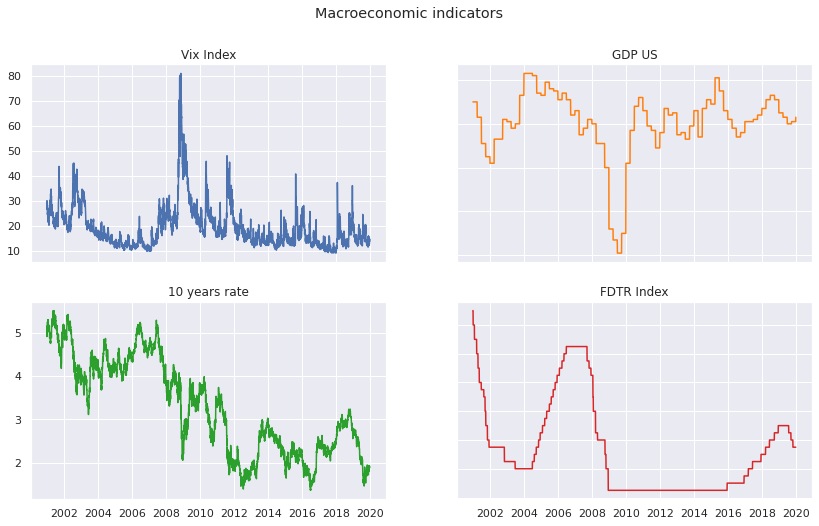

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,8))
fig.suptitle('Macroeconomic indicators')
ax1.plot(df_daily_data['Vix Index'])
ax1.set_title("Vix Index")
ax2.plot(df_daily_data['GDP US'], 'tab:orange')
ax2.set_title("GDP US")
ax3.plot(df_daily_data['Taux 10 ans US'], 'tab:green')
ax3.set_title("10 years rate")
ax4.plot(df_daily_data['FDTR Index'], 'tab:red')
ax4.set_title("FDTR Index")

for ax in fig.get_axes():
    ax.label_outer()

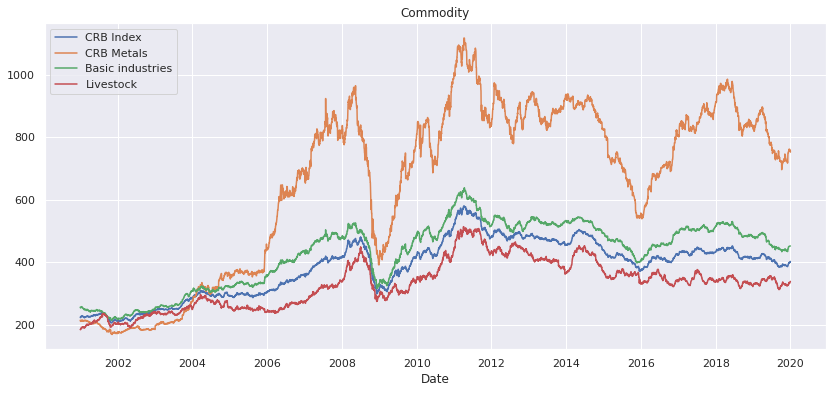

In [ ]:
plt.figure(figsize=(14,6))
plt.plot(df_daily_data["Indice CRB"], label="CRB Index")
plt.plot(df_daily_data["CRB - Métaux"], label="CRB Metals") 
plt.plot(df_daily_data["CRB - Industrie de base"], label="Basic industries")
plt.plot(df_daily_data["CRB - Alimentaire"], label="Livestock")
#plt.ylabel('commo', fontsize=16)
plt.xlabel('Date')
plt.title('Commodity') 
plt.legend()

## **Compute closing price**

In [ ]:
def compute_price(df):
  df['Closing Price'] = 1320.28*(1+df['SPX Index'].copy()/100).cumprod()
  return df

In [ ]:
df_daily_data = compute_price(df_daily_data)

## **WAVELET TRANSFORM : Denoise closing price before making it stationary**

**Compute a function that determine the best wavelet transformation based on criteria like rmse & snr**

In [ ]:
def get_best_wavelet(df):
    wavelet_list = ['haar', 'sym3','coif3', 'db3']
    scale = 0.05
    dic = {}
    for wavelet in wavelet_list:
        coefficients = pywt.wavedec(df, wavelet, mode = 'smooth')
        coefficients[1:] = [pywt.threshold(i, value = scale * df.max(), mode = 'garotte') for i in coefficients[1:]]
        reconstructed_SPX = pywt.waverec(coefficients, wavelet, mode = 'smooth')
        snr = 10*math.log(sum(reconstructed_SPX**2)/sum((df-reconstructed_SPX)**2))
        rmse = math.sqrt(metrics.mean_squared_error(df, reconstructed_SPX))
        dic[wavelet] = [wavelet, snr, rmse]
    return dic
dic = get_best_wavelet(df_daily_data['Closing Price'])
df_params = pd.DataFrame(dic, index=['wavelet', 'SNR', 'RMSE'])

In [ ]:
df_params

,haar,sym3,coif3,db3
wavelet,haar,sym3,coif3,db3
SNR,81.6796,83.3746,84.2824,83.3746
RMSE,28.4686,26.1596,24.9941,26.1596


**Denoised the closing price before feeding it to our models**

In [ ]:
scale = 0.05
coefficients = pywt.wavedec(df_daily_data['Closing Price'], 'coif3', mode = 'smooth')
coefficients[1:] = [pywt.threshold(i, value = scale * df_daily_data['Closing Price'].max(), mode = 'garotte') for i in coefficients[1:]]
reconstructed_SPX = pywt.waverec(coefficients, 'coif3', mode = 'smooth')
reconstructed_SPX = pd.DataFrame(reconstructed_SPX, columns=['Closing Price'], index=df_daily_data.index)

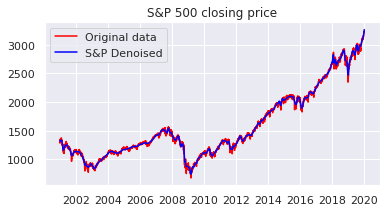

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(df_daily_data['Closing Price'], label='Original data', color='red')
plt.plot(reconstructed_SPX['Closing Price'], label='S&P Denoised', color='blue')
plt.title("S&P 500 closing price")
plt.legend()
plt.show()

---
> **The figures below show the closing price curves before and after denoising using the wavelet transform. By comparing them, it is found that the noise after wavelet transform processing is smaller.**

---



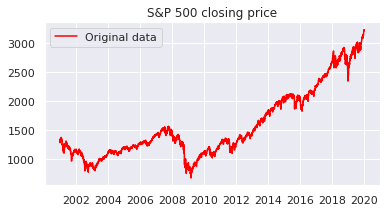

In [ ]:
plt.figure(figsize=(6,3))
plt.plot(df_daily_data['Closing Price'], label='Original data', color='red')
#plt.plot(reconstructed_SPX['closing_price'], label='S&P Denoised', color='blue')
plt.title("S&P 500 closing price")
plt.legend()
plt.show()

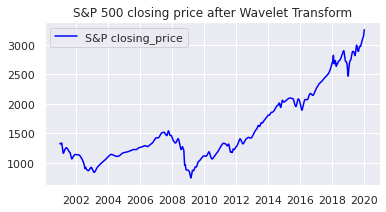

In [ ]:
plt.figure(figsize=(6,3))
#plt.plot(df['closing_price'], label='Original data', color='red')
plt.plot(reconstructed_SPX, label='S&P closing_price', color='blue')
plt.title("S&P 500 closing price after Wavelet Transform")
plt.legend()
plt.show()

**Download S&P 500 open, high, low prices and the volume**

In [ ]:
start = dt.datetime(2000, 12, 31)
end = dt.datetime(2019, 12, 31)

df_SPX_stocks = web.DataReader(['^GSPC'], 'yahoo', start, end)
df_SPX_stocks.columns = ['Ajd Close', 'Close', 'High', 'Low' ,'Open', 'Volume']
df_SPX_stocks

,Ajd Close,Close,High,Low,Open,Volume
Date,,,,,,
2001-01-02,1283.270020,1283.270020,1320.280029,1276.050049,1320.280029,1129400000
2001-01-03,1347.560059,1347.560059,1347.760010,1274.619995,1283.270020,1880700000
2001-01-04,1333.339966,1333.339966,1350.239990,1329.140015,1347.560059,2131000000
2001-01-05,1298.349976,1298.349976,1334.770020,1294.949951,1333.339966,1430800000
2001-01-08,1295.859985,1295.859985,1298.349976,1276.290039,1298.349976,1115500000
...,...,...,...,...,...,...
2019-12-24,3223.379883,3223.379883,3226.429932,3220.510010,3225.449951,1296540000
2019-12-26,3239.909912,3239.909912,3240.080078,3227.199951,3227.199951,2160680000
2019-12-27,3240.020020,3240.020020,3247.929932,3234.370117,3247.229980,2428670000


**Compute technical indicators for trends modeling**

In [ ]:
stock_df = Sdf.retype(df_SPX_stocks)
df_SPX_stocks['rsi']=stock_df['rsi_14']
del df_SPX_stocks['close_-1_s']
del df_SPX_stocks['close_-1_d']
del df_SPX_stocks['rs_14']
del df_SPX_stocks['rsi_14']
del df_SPX_stocks['closepm']
del df_SPX_stocks['closenm']
del df_SPX_stocks['closepm_14_smma']
del df_SPX_stocks['closenm_14_smma']


df_SPX_stocks['CCI']=stock_df['cci']
df_SPX_stocks['STCK%']=stock_df['kdjk']
df_SPX_stocks['ADO'] = (df_SPX_stocks['high'] - df_SPX_stocks['close'])/(df_SPX_stocks['high']-df_SPX_stocks['low'])

In [ ]:
df_SPX_stocks.head()

,ajd close,close,high,low,open,volume,rsi,CCI,STCK%,ADO
Date,,,,,,,,,,
2001-01-02,1283.270020,1283.270020,1320.280029,1276.050049,1320.280029,1129400000,NaN,NaN,38.774568,0.836763
2001-01-03,1347.560059,1347.560059,1347.760010,1274.619995,1283.270020,1880700000,100.000000,66.666667,59.091918,0.002734
2001-01-04,1333.339966,1333.339966,1350.239990,1329.140015,1347.560059,2131000000,80.762337,78.716507,65.278406,0.800950
2001-01-05,1298.349976,1298.349976,1334.770020,1294.949951,1333.339966,1430800000,53.492969,-29.735146,53.979125,0.914615
2001-01-08,1295.859985,1295.859985,1298.349976,1276.290039,1298.349976,1115500000,52.143676,-86.857456,45.348682,0.112874


**Get rid of holidays, weekends ang keep only business days**

In [ ]:
class BankCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday("New Year's Day", month=1, day=1, observance=sunday_to_monday),
        Holiday("Martin Luther King Jr.'s Birthday", month=1, day=1, offset=WeekOfMonth(week=3, weekday=1)),
        Holiday("Washington's Birthday", month=2, day=1, offset=WeekOfMonth(week=3, weekday=1)),
        USMemorialDay,
        Holiday("Independence Day", month=7, day=4, observance=sunday_to_monday),
        USLaborDay,
        USColumbusDay,
        Holiday("Veteran's Day", month=11, day=11, observance=sunday_to_monday),
        USThanksgivingDay,
        Holiday("Christmas Day", month=12, day=25, observance=sunday_to_monday),
    ]

# Keep only bank business days
Bank_business_days = CustomBusinessDay(calendar = BankCalendar())
business_days = pd.date_range('2000-12-31', end = '2019-12-31', freq = Bank_business_days)
df_business_days = pd.DataFrame(business_days, columns = ['Date'])
df_business_days.set_index('Date', inplace = True, drop = True)
df_daily_data = df_daily_data.join(df_business_days, how = 'right')

In [ ]:
df_daily_data = df_daily_data.merge(df_SPX_stocks, how='inner', on='Date')

In [ ]:
df_daily_data.head()

,SPX Index,Vix Index,GDP US,Taux 10 ans US,FDTR Index,Indice CRB,CRB - Métaux,CRB - Industrie de base,CRB - Alimentaire,CRB - Textile,MACD,BSPGCPUS Index,Surprise économique,Or,Chômage US,Confiance des consommateurs US,Inflation US,CPTICHNG Index,Closing Price,ajd close,close,high,low,open,volume,rsi,CCI,STCK%,ADO
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-02,-2.80,29.99,3.0,4.915,6.5,222.54,211.24,253.76,183.96,244.15,-15.078643,5.7,-0.218,270.0,3.9,128.55,3.4,79.9609,1283.312160,1283.270020,1283.270020,1320.280029,1276.050049,1320.280029,1129400000,NaN,NaN,38.774568,0.836763
2001-01-03,5.01,26.60,3.0,5.158,6.0,222.53,210.76,253.53,184.17,244.15,-11.375763,5.7,-0.218,269.3,3.9,128.55,3.4,79.9609,1347.606099,1347.560059,1347.560059,1347.760010,1274.619995,1283.270020,1880700000,100.000000,66.666667,59.091918,0.002734
2001-01-04,-1.06,26.97,3.0,5.039,6.0,222.80,210.62,253.95,184.29,243.49,-9.479367,5.7,-0.218,268.4,3.9,128.55,3.4,79.9609,1333.321475,1333.339966,1333.339966,1350.239990,1329.140015,1347.560059,2131000000,80.762337,78.716507,65.278406,0.800950
2001-01-05,-2.62,28.67,3.0,4.931,6.0,223.70,210.83,254.36,185.68,243.43,-10.676785,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609,1298.388452,1298.349976,1298.349976,1334.770020,1294.949951,1333.339966,1430800000,53.492969,-29.735146,53.979125,0.914615
2001-01-08,-0.19,29.84,3.0,4.956,6.0,224.48,211.59,255.17,186.40,244.80,-11.691893,5.7,-0.218,269.0,3.9,128.55,3.4,79.9609,1295.921514,1295.859985,1295.859985,1298.349976,1276.290039,1298.349976,1115500000,52.143676,-86.857456,45.348682,0.112874


In [ ]:
df_relevant_indicators = df_daily_data[['SPX Index', 'FDTR Index', 'Vix Index', 'Surprise économique', 'Inflation US', 'Confiance des consommateurs US', 'Taux 10 ans US', 'close', 'Chômage US']]
df_relevant_indicators.head(5)

,SPX Index,FDTR Index,Vix Index,Surprise économique,Inflation US,Confiance des consommateurs US,Taux 10 ans US,close,Chômage US
Date,,,,,,,,,
2001-01-02,-2.80,6.5,29.99,-0.218,3.4,128.55,4.915,1283.270020,3.9
2001-01-03,5.01,6.0,26.60,-0.218,3.4,128.55,5.158,1347.560059,3.9
2001-01-04,-1.06,6.0,26.97,-0.218,3.4,128.55,5.039,1333.339966,3.9
2001-01-05,-2.62,6.0,28.67,-0.218,3.4,128.55,4.931,1298.349976,3.9
2001-01-08,-0.19,6.0,29.84,-0.218,3.4,128.55,4.956,1295.859985,3.9


# **Trends**

In [ ]:
df_trends_indicator = df_daily_data[['close', 'rsi', 'MACD', 'CCI', 'STCK%', 'ADO']]

def ado_stck_macd_trends(data, name):
  indicator = [None]
  for i in range(len(data) - 1):
    if data[name][i+1] > data[name][i]:
      indicator.append(1)
    else:
      indicator.append(0)
  return indicator

df_trends_indicator['ADO_trends'] = ado_stck_macd_trends(df_trends_indicator, 'ADO')
df_trends_indicator['STCK%_trends'] = ado_stck_macd_trends(df_trends_indicator, 'STCK%')
df_trends_indicator['MACD_trends'] = ado_stck_macd_trends(df_trends_indicator, 'MACD')

In [ ]:
df_trends_indicator = df_trends_indicator[1:]
df_trends_indicator.head()

,close,rsi,MACD,CCI,STCK%,ADO,ADO_trends,STCK%_trends,MACD_trends
Date,,,,,,,,,
2001-01-03,1347.560059,100.000000,-11.375763,66.666667,59.091918,0.002734,0.0,1.0,1.0
2001-01-04,1333.339966,80.762337,-9.479367,78.716507,65.278406,0.800950,1.0,1.0,1.0
2001-01-05,1298.349976,53.492969,-10.676785,-29.735146,53.979125,0.914615,1.0,0.0,0.0
2001-01-08,1295.859985,52.143676,-11.691893,-86.857456,45.348682,0.112874,0.0,0.0,0.0
2001-01-09,1300.800049,54.590891,-11.959890,-32.288047,41.772636,0.658622,1.0,0.0,0.0


In [ ]:
def trends_model_difference(df, trends_window):
  n = len(df)
  trends = []
  for i in range(trends_window - 1, n):
    if df[i] - df[i - trends_window + 1] > 0:
      trends.append(1)
    else :
      trends.append(0)
  if len(trends) == 1:
    return trends[0]
  else :
    return trends

# **Train test split**

In [ ]:
df_arimax = df_relevant_indicators.reset_index(drop=True)
target = df_arimax[['close']]
del df_arimax['SPX Index']
del df_arimax['close']

In [ ]:
df_train_arimax = df_arimax[:int(0.8*(len(df_arimax)))]
target_snp = target[:int(0.8*(len(target)))]
df_test_arimax = df_arimax[int(0.8*(len(df_arimax))):]
valid = target[int(0.8*(len(target))):]

In [ ]:
valid

,close
3764,2049.580078
3765,2051.600098
3766,2049.800049
3767,2036.709961
3768,2035.939941
...,...
4700,3223.379883
4701,3239.909912
4702,3240.020020
4703,3221.290039


***
# **WHICH MODEL TO USE** ?
***

Which model should we be using for S&P 500 price forecasting with macroeconomic variables ? 

* **ARIMA-ARMA with external regressors (macroeconomics variables)**

* **Multivariate VAR**

It seems reasonable to think that our predictors (ie Unemployment, GDP etc.) are causal for the S&P 500 and not the other way around. We therefore can use a model like **Autoregressive Integrated Moving Average with Exogenous Inputs (ARIMAX)**. If on the other hand, our times series all depend on each other, then the use of **Vector AutoRegressive (VAR)** makes sense.

## **Stationary** ?

In [ ]:
stationary = adfuller(df_relevant_indicators['close'])
print('\033[1m' + 'ADF Statistic: %f' % stationary[0])
print('p-value: %f' % stationary[1])
print('Critical Values:')
for key, value in stationary[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.499958
p-value: 0.997524
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


-----

*As expected, the p-value which is equals to 0.99 is greater than 0.05. Our time series is therefore non stationary. We are going to make it stationary by differenciating. Let's use pandas diff() function.*

-----


In [ ]:
df_stat = df_relevant_indicators['close'].diff()
df_stat.head(5)

Date
2001-01-02          NaN
2001-01-03    64.290039
2001-01-04   -14.220093
2001-01-05   -34.989990
2001-01-08    -2.489990
Name: close, dtype: float64

In [ ]:
result = adfuller(df_stat.dropna())
print('\033[94m')
print('\033[1m' + 'ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))


ADF Statistic: -17.306337
p-value: 0.000000
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


**One differenciating makes the stock price stationary. For our ARIMA model, our model d parameter will therefore be set to $d=1$. Let's plot our stationary time series**

## **ARIMAX-ARMAX Model**

ARIMAX are ARIMA models which include exogenous regressors. Here the macroecomics variables.

The general steps to implement an ARIMA model are –

1. **Load the data**
2. **Preprocessing**
3. **Make series stationary**
4. **Determine d value**
5. **Create ACF and PACF plots** 
6. **Determine the p and q values**
7. **Fit ARIMA model**
8. **Predict the future values**
9. **Evaluate model**



```
# Auto_arima helps get the best model without having to do steps 3, 4, 5 and 6. 
```




---
### **Build model**
---

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
mymodel = ARIMA(target_snp, order=(2,1,2), exog=df_train_arimax) 

In [ ]:
fitted = mymodel.fit(method='css-mle', trend='c')
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.close   No. Observations:                 3763
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -15453.058
Method:                       css-mle   S.D. of innovations             14.697
Date:                Sun, 11 Apr 2021   AIC                          30932.116
Time:                        13:47:09   BIC                          31013.145
Sample:                             1   HQIC                         30960.928
                                                                              
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                             16.6597      4.439      3.753      0.000       7.960      25.359
FDTR Index                        -0.0301      0.273     -0.110      0.912      -0.566       0.506
Vix Index                         -0.3084      0.031     -9.888      0.000      -0.369      -0.247
Surprise économique               -0.6077      0.879     -0.691      0.489      -2.330       1.115
Inflation US                      -0.5864      0.216     -2.716      0.007      -1.010      -0.163
Confiance des consommateurs US    -0.1058      0.025     -4.163      0.000      -0.156      -0.056
Taux 10 ans US                     0.8440      0.371      2.274      0.023       0.117       1.571
Chômage US                        -0.4809      0.318     -1.513      0.130      -1.104       0.142
ar.L1.D.close                      0.1704      0.112      1.516      0.130      -0.050       0.391
ar.L2.D.close                     -0.7612      0.078     -9.744      0.000      -0.914      -0.608
ma.L1.D.close                     -0.2276      0.114     -1.996      0.046      -0.451      -0.004
ma.L2.D.close                      0.7662      0.074     10.400      0.000       0.622       0.911
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.1119           -1.1407j            1.1462           -0.2344
AR.2            0.1119           +1.1407j            1.1462            0.2344
MA.1            0.1485           -1.1327j            1.1424           -0.2292
MA.2            0.1485           +1.1327j            1.1424            0.2292
-----------------------------------------------------------------------------
"""

# **Residuals**

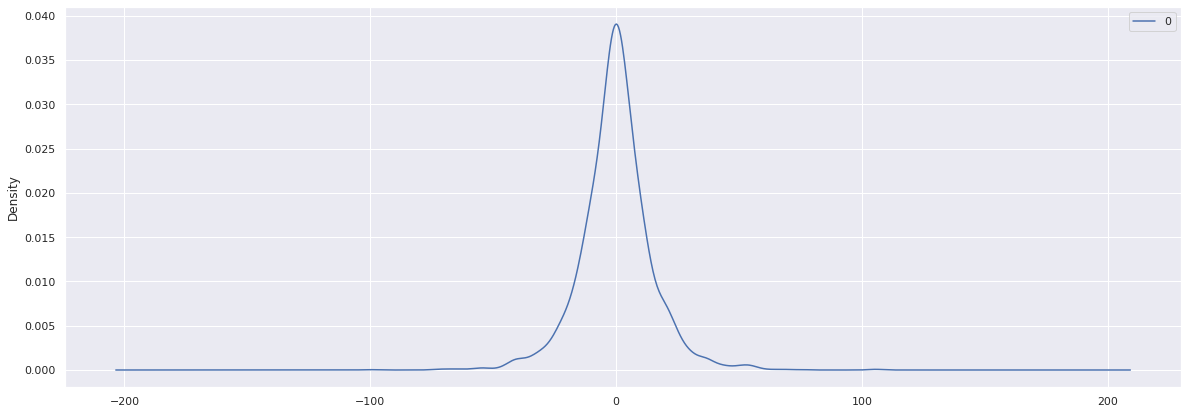

In [ ]:
residuals = pd.DataFrame(fitted.resid)
residuals.plot(kind='kde')
plt.show()

---
### **Forecast stock price given a time horizon**
---


In [ ]:
df_test_arimax[0:6]

,FDTR Index,Vix Index,Surprise économique,Inflation US,Confiance des consommateurs US,Taux 10 ans US,Chômage US
3764,0.5,14.02,-0.274,1.0,94.0,1.8732,4.9
3765,0.5,13.79,-0.274,1.0,94.0,1.9155,4.9
3766,0.5,14.17,-0.274,1.0,94.0,1.9403,4.9
3767,0.5,14.94,-0.274,1.0,94.0,1.8786,4.9
3768,0.5,14.74,-0.274,1.0,94.0,1.9000,4.9
3769,0.5,15.24,-0.274,1.0,94.0,1.8860,4.9


In [ ]:
def predictions(step, fitted_model, start_index, df_test):
  start = start_index
  end = start + step
  predictions = []
  for i in range(0, len(df_test) - step, step):
    fc_arima = fitted.predict(start=start + i, end=end + i, exog=df_test[i:i+step ], typ='levels')
    predictions.append(fc_arima)
  return predictions

In [ ]:
predictions(5, fitted, 3764, df_test_arimax)

In [ ]:
step = 5
start = 3764
end = start + step

In [ ]:
test = df_test_arimax.reset_index(drop=True)
test

,FDTR Index,Vix Index,Surprise économique,Inflation US,Confiance des consommateurs US,Taux 10 ans US,Chômage US
0,0.50,14.02,-0.274,1.0,94.0,1.8732,4.9
1,0.50,13.79,-0.274,1.0,94.0,1.9155,4.9
2,0.50,14.17,-0.274,1.0,94.0,1.9403,4.9
3,0.50,14.94,-0.274,1.0,94.0,1.8786,4.9
4,0.50,14.74,-0.274,1.0,94.0,1.9000,4.9
...,...,...,...,...,...,...,...
936,1.75,12.67,0.138,2.1,126.8,1.8996,3.5
937,1.75,12.65,0.138,2.1,126.8,1.8944,3.5
938,1.75,13.43,0.138,2.1,126.8,1.8752,3.5
939,1.75,14.82,0.138,2.1,126.8,1.8788,3.5


In [ ]:
fitted.predict(start=start+1, end=end+1  , exog=test[:step+3], typ='levels')

In [ ]:
zfitted.predict(start=start + step, end=end + step, exog=df_test_arimax[], typ='levels')

In [ ]:
predictions = []
step = 10
start = 3764
end = start + step
for i in range(0, len_data - step, step):
  forecast = fitted.predict(start=start, end=end, exog=df_test_arimax[i:step + i], typ='levels')
  predictions.append(forecast)

3763    2039.842969
3764    2040.925635
3765    2043.546867
3766    2044.845606
3767    2044.803700
3768    2045.140045
3769    2047.018536
dtype: float64

### **Recall - Precision - F1_score - AUC**

**Recall**, or **sensitivity**, is the rate of true positives, i.e. the proportion of positives that have been correctly identified.

In [ ]:
from sklearn import metrics

In [ ]:
def metrics_classification_report(expected, predicted, trends_model):
  df_metrics_report = pd.DataFrame(columns = [trends_model], index = ['Accuracy', 'F1', 'Recall', 'Precision','Specificity'])
  df_metrics_report[trends_model]['Accuracy'] = metrics.accuracy_score(expected, predicted)
  df_metrics_report[trends_model]['F1'] = metrics.f1_score(expected, predicted)
  df_metrics_report[trends_model]['Precision'] = metrics.precision_score(expected, predicted)
  df_metrics_report[trends_model]['Recall'] = metrics.recall_score(expected, predicted)
  tn, fp, fn, tp = metrics.confusion_matrix(expected, predicted).ravel()
  df_metrics_report[trends_model]['Specificity'] = tn/(fp + tn)
  return df_metrics_report

In [ ]:
def trends_forecast_arima(fitted_model, step, len_data):
  predictions = []
  for i in range(0, len_data - step, step):
    forecast, se, conf = fitted_model.forecast(step, exog=df_test_arimax[i:i+step],alpha=0.05)
    predictions.append(forecast)
  return predictions

In [ ]:
trends_window_1_arima = 5

In [ ]:
pred = trends_forecast_arima(fitted, trends_window_1_arima, len(valid))

In [ ]:
L = []
for elem in pred:
  for i in elem:
    L.append(i)

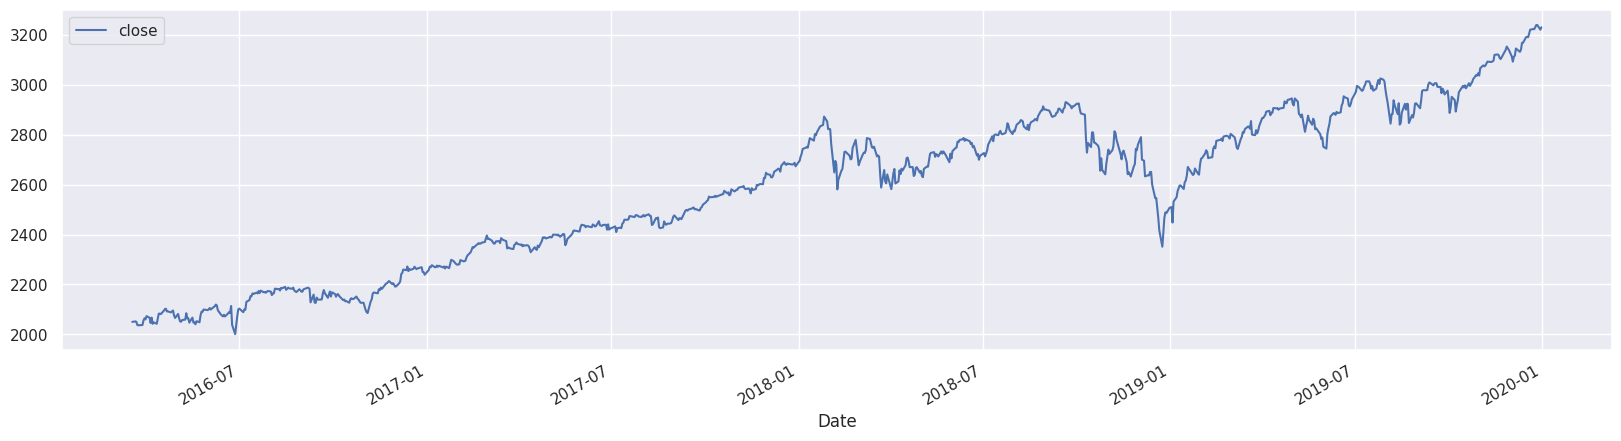

In [ ]:
valid.plot()

In [ ]:
df_predict = pd.DataFrame(L, columns=['close'])

In [ ]:
df_predict.head(15)

,close
0,2039.842969
1,2040.925635
2,2043.546867
3,2044.845606
4,2044.803700
5,2039.477559
6,2040.456448
7,2043.166618
8,2044.293639
9,2044.263912


In [ ]:
actual_trends = trends_model_difference(valid['close'][:-1], trends_window_1_arima)
predicted_trends = trends_model_difference(df_predict['close'], trends_window_1_arima)

In [ ]:
df_trends = pd.DataFrame(predicted_trends, columns=['Pred'])
df_trends['Actual'] = actual_trends

In [ ]:
df_trends

,Pred,Actual
0,1,0
1,0,0
2,0,1
3,0,1
4,0,1
...,...,...
931,1,1
932,1,1
933,1,1
934,1,1


In [ ]:
df_metrics_closing_price_difference_arima = metrics_classification_report(df_trends['Actual'], df_trends['Pred'], 'Difference-' + str(trends_window_1_arima))
df_metrics_closing_price_difference_arima

,Difference-5
Accuracy,0.634615
F1,0.702091
Recall,0.686542
Precision,0.71836
Specificity,0.547278


In [ ]:
actual_label, actual_label_count = np.unique(df_trends['Actual'], return_counts = True)
data_dict = dict(zip(actual_label, actual_label_count))

print('Actual labels: ', dict(zip(actual_label, actual_label_count)))
forecasted_labels = df_trends['Pred']
get_confusion_matrix = metrics.confusion_matrix(df_trends['Actual'], df_trends['Pred'])

predicted_labels, predicted_label_counts = np.unique(df_trends['Pred'], return_counts = True)
print('Predicted labels: ', dict(zip(predicted_labels, predicted_label_counts)))
print(' ')
print('Confusion matrix of predicted data:')
print(pd.DataFrame(get_confusion_matrix))
print(' ')

for i in range(len(predicted_labels)):
    print('Label {0} accuracy: {1:0.1f}%'.format(i, 100 * get_confusion_matrix[i,i]/actual_label_count[i]))

Actual labels:  {0: 349, 1: 587}
Predicted labels:  {0: 375, 1: 561}
 
Confusion matrix of predicted data:
     0    1
0  191  158
1  184  403
 
Label 0 accuracy: 54.7%
Label 1 accuracy: 68.7%


In [ ]:
def plot_confusion_matrix(df_confusion_matrix):
  fig = sns.heatmap(df_confusion_matrix, annot = True, fmt = 'g' )
  fig.set_xlabel('Actual trends')
  fig.set_ylabel('Predicted trends')
  fig.set_title('Confusion Matrix ')
  fig.xaxis.set_ticklabels(['Positives', 'Negatives'])
  fig.yaxis.set_ticklabels(['Positives', 'Negatives'])

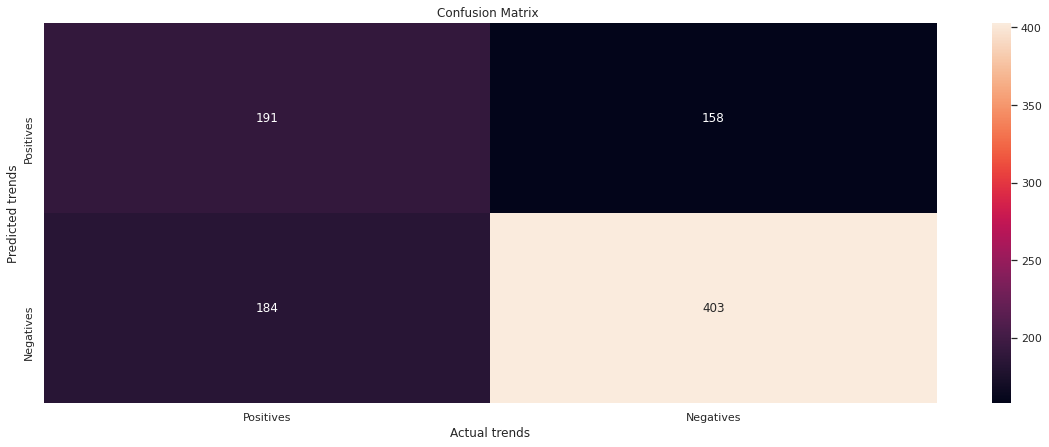

In [ ]:
plot_confusion_matrix(confusion_matrix(df_trends['Actual'], df_trends['Pred']))

In [ ]:
spx = df_relevant_indicators['SPX Index']
n_train = int(0.8*(len(spx)))
df_spx = spx[n_train:]

In [ ]:
y = []
for i in range(len(df_spx[trends_window_1_arima:])):
  y.append(df_spx[trends_window_1_arima:][i])
y = np.array(y)

In [ ]:
base = 100
df = pd.DataFrame({'SXP Index' : y, 'LSTM' : df_trends['Pred'], 'Optimal': df_trends['Actual']})
df['LSTMr'] = df['SXP Index'] * df['LSTM']
df['Closing Price'] = base * (1 + df['SXP Index'].copy()/100).cumprod()
df['Closing Price Bot'] = base * (1 + df['LSTMr'].copy()/100).cumprod()
df['LSTMth'] = df['SXP Index'] * df['Optimal']

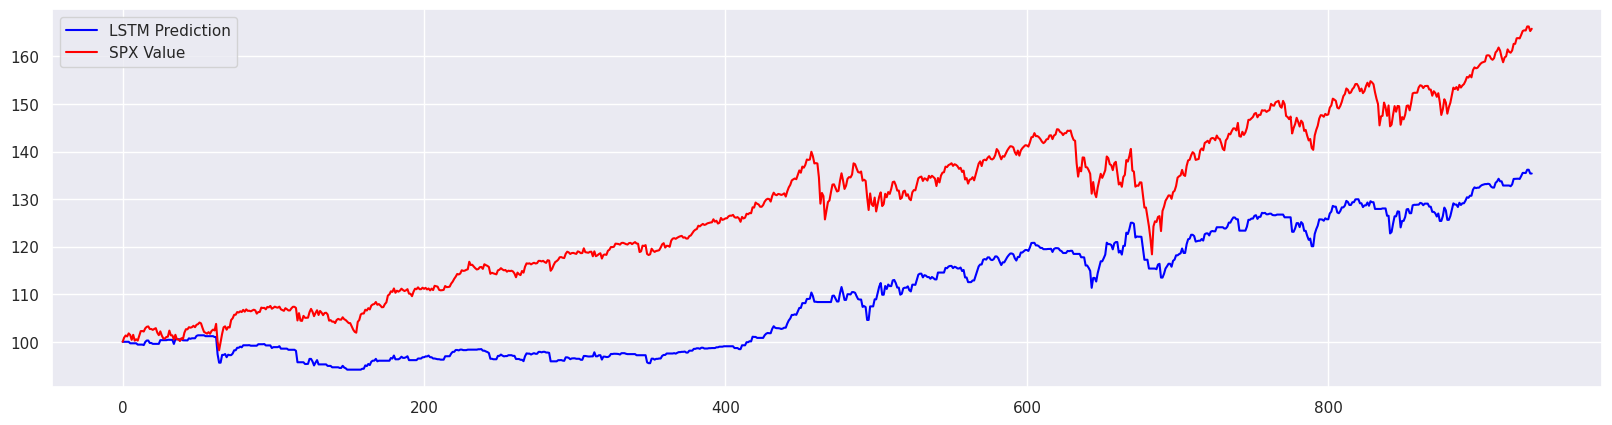

In [ ]:
plt.rcParams.update({'figure.figsize':(20,5), 'figure.dpi':100})
plt.plot(df['Closing Price Bot'], color = 'blue', label = 'LSTM Prediction')
plt.plot(df['Closing Price'], color = 'red', label = 'SPX Value')
plt.legend()
plt.show()